# Coronavirus articles

En esta notebook mostraremos algunos 

In [1]:
%load_ext autoreload
%autoreload 2
from mongoengine import connect
from tweepyrate import create_apps
from hatespeech_models import Tweet, Article

client = connect("hatespeech-news")


print(f"Tenemos {Article.objects.count()} artículos")

Tenemos 48984 artículos


Busquemos artículos con:

* 10 comentarios al menos
* Con al menos un comentario marcado como odioso
* Que hable de Coronavirus

In [2]:
initial_query = {
    "comments__10__exists": True,
    "comments__hateful_value__gt": 0.5
}
articles = Article.objects(**initial_query).search_text('chinos')
print(articles.count())

970


Contemos comentarios con odio

Salvo primero todo esto!

In [3]:
articles = list(articles)

In [5]:
from tqdm.auto import tqdm
import numpy as np
threshold = 0.5

for article in tqdm(articles):
    values = np.array([com.hateful_value for com in article.comments])
    article.hateful_comments_count = sum(values > threshold)
    article.mean_value = values.mean()
    

Vamos a quedarnos sólo con aquellos que tienen más de dos comentarios odiosos


Text(0, 0.5, 'Cantidad de comentarios')

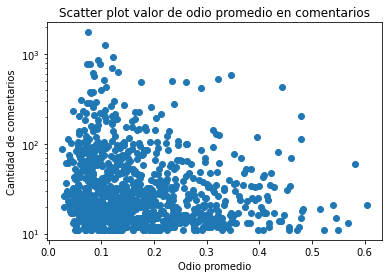

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter([art.mean_value for art in articles], [len(art.comments) for art in articles]);

plt.semilogy()
plt.title("Scatter plot valor de odio promedio en comentarios")
plt.xlabel("Odio promedio")
plt.ylabel("Cantidad de comentarios")

In [9]:
hateful_articles = [art for art in articles if art.mean_value > 0.3]

print(f"Hay {len(hateful_articles)} artículos")

Hay 127 artículos


In [10]:
from termcolor import cprint

def display_article(article):
    print("Artículo:", end="")
    print(article)
        
    for comment in article.comments: 
        print(f"{comment.hateful_value:.2f} --", end = "")
        attrs = []
        
        if comment.hateful_value > threshold:
            attrs.append("bold")
        cprint(f"{comment.text}", attrs=attrs)



In [11]:

for art in hateful_articles:
    display_article(art)
    print(("="*80 + '\n')*5)

Artículo:1228985028119494663 - latercera
Marcelo Ríos: “Si viera a gente robando leche y tuviera a mi hijo cagado de hambre, muriéndose, yo también saquearía”

(126 comentarios)
Tweet:
#LTDomingo | Marcelo Ríos: “Si viera a gente robando leche y tuviera a mi hijo cagado de hambre, muriéndose, yo también saquearía” https://t.co/ErrX4WKc6q https://t.co/CWSyZ95IIh
    
0.01 --@latercera En chile , nadie muere de hambre ¡¡
0.99 --@latercera Los weones que saquean, tienen droga......
0.02 --@latercera ....... y. queman la leche.......
0.87 --@latercera Pero aquí en Chile nadie pasa hambre, la purita te la dan en el consultorio desde el embarazo y muchas la venden en la feria o en Facebook
0.83 --@latercera Este se ve que  no conoce chile,menos el flaite chileno drogo.solo los de su raza.
0.01 --@latercera El Chino habla  tonterías las vacunas y la leche son gratis en los consultorios,te dan 2 a3 kilos mensuales.
0.00 --@latercera Ese escenario de hambruna descrito por Rios no es el contexto

In [16]:
import json

articles = Article.objects(**initial_query).search_text('chinos')

with open("../dumps/articulos_chinos.json", "w") as f:
    json.dump(articles.to_json(), f)